***
**Exploratory Data Analysis of GDPs & Nations' Energy supplies/production.**
***

### Datasets:
1. Load the energy data from the file `Energy Indicators.xls`, which is a list of indicators of [energy supply and renewable electricity production](Energy%20Indicators.xls) from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013.

2. Next, load the GDP data from the file `world_bank.csv`, which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD).

3. Finally, load the [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102) from the file `scimagojr-3.xlsx`, which ranks countries based on their journal contributions in the aforementioned area.

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
'''Renaming some countries in the Energy DF and cleaning up parenthesis etc.'''
def cleanEnergyDF(row):
    if row['Country'] == 'Republic of Korea':
        row['Country'] = 'South Korea'
    elif row['Country'].find('United States of America') != -1:
        row['Country'] = 'United States'
    elif row['Country'].find('United Kingdom of Great Britain and Northern Ireland') != -1:
        row['Country'] = 'United Kingdom'   
    elif row['Country'].find('China, Hong Kong Special Administrative Region') != -1:
        row['Country'] = 'Hong Kong'  
    row['Country'] =  re.sub('\(.*\)', '', row['Country'])   
    row['Country'] =  re.sub('[0-9]+', '', row['Country'])
    row['Country'] =  re.sub('\s+$', '', row['Country'])
    return row  

In [3]:
'''Renaming some countries in the GDP DF and cleaning up parenthesis etc.'''
def cleanGDP_DF(row):
    if row['Country'].find('Korea, Rep.') != -1:
        row['Country'] = 'South Korea'
    elif row['Country'].find('Iran, Islamic Rep.') != -1:
        row['Country'] = 'Iran'
    elif row['Country'].find('Hong Kong SAR, China') != -1:
        row['Country'] = 'Hong Kong' 
        
    row['Country'] =  re.sub('\(.*\)', '', row['Country'])   
    row['Country'] =  re.sub('[0-9]+', '', row['Country'])
    row['Country'] =  re.sub('\s+$', '', row['Country'])

    return row  

In [4]:
def loadData():
    energy=pd.read_excel('Energy Indicators.xls', usecols=['Country', 'Energy Supply', 'Energy Supply per capita', 'Renewable Electricity Production'],              
                     header=9,skipfooter=38, skiprows=[10,11,12,13,14,15,16,17]) 
    energy.columns=['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']
    energy.replace('...', np.NaN,inplace=True)
    energy['Energy Supply'] = energy['Energy Supply']*1000000
    energy=energy.apply(cleanEnergyDF, axis=1)
    
    GDP=pd.read_csv('world_bank.csv', header=4,
                usecols=['Country Name','2006','2007','2008','2009',
                        '2010','2011','2012','2013','2014','2015'])
    GDP.rename(columns={'Country Name':'Country'}, inplace=True)
    GDP=GDP.apply(cleanGDP_DF, axis=1)
    ScimEn = pd.read_excel('scimagojr-3.xlsx')
    
    SciEneGDPFull=pd.merge(pd.merge(ScimEn,energy, how='inner', left_on ='Country' , right_on ='Country'), 
                   GDP,  how='inner', left_on ='Country' , right_on ='Country')
    SciEneGDP=SciEneGDPFull[SciEneGDPFull['Rank']<16]
    SciEneGDP.set_index('Country', inplace=True)    
    return SciEneGDP

In [5]:
# Average GDP over the last 10 years for each country (top 15 countries)
Top15 = loadData()
row=['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
avgGDP = Top15.apply(lambda x: np.average(x[row]), axis=1).sort_values(ascending=False)
avgGDP

Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                           NaN
dtype: float64

In [6]:
#By how much had the GDP changed over the 10 year span for the top 15 countries
def min_max(row):
    data = row[['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']]
    return pd.Series({'diff':np.max(data) - np.min(data)})
Top15.apply(min_max, axis=1)

,diff
Country,
China,4.805667e+12
United States,1.953731e+12
Japan,4.182547e+11
United Kingdom,2.992858e+11
Russian Federation,2.929162e+11
Canada,2.281399e+11
Germany,4.022160e+11
India,1.101312e+12
France,1.652185e+11


In [7]:
# Mean Energy Supply per Capita
np.mean(Top15['Energy Supply per Capita'])

157.6

In [8]:
# Country with the maximum % Renewable evergy and the value:
Top15[Top15['% Renewable']==np.max(Top15['% Renewable'])].index[0],np.max(Top15['% Renewable'])

('Brazil', 69.64803)

In [9]:
# Country has the highest ratio of Self-Citations to Total Citations
Top15['Self-Total'] = Top15["Self-citations"] / Top15["Citations"]
Top15['Self-Total'].idxmax(), Top15['Self-Total'].max()

('China', 0.6893126179389422)

In [10]:
# Third most populous country according to the population using Energy Supply and Energy Supply per capita.
Top15['Population'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
Top15.sort_values(by='Population', ascending=False).index[2]

'United States'

In [11]:
# Correlation between the number of citable documents per capita and the energy supply per capita.
Top15['Population'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
Top15['citable documents per capita'] = Top15['Citable documents'] / Top15['Population'] 
Top15.corr(method ='pearson').loc['citable documents per capita','Energy Supply per Capita']

0.7940010435442943

In [12]:
# Display the sample size (the number of countries in each continent bin), and the sum, mean, and std deviation for the 
# estimated population of each country.
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
finalDF = pd.DataFrame(columns=['size', 'sum', 'mean', 'std'])
Top15['Population'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
Top15grp=Top15.groupby(ContinentDict)
for grp,frame in Top15grp:
    finalDF.loc[grp]=[len(frame), np.sum(frame['Population']), np.mean(frame['Population']), np.std(frame['Population'])]
finalDF

,size,sum,mean,std
Asia,5.0,2.898666e+09,5.797333e+08,6.074036e+08
Australia,1.0,2.331602e+07,2.331602e+07,0.000000e+00
Europe,6.0,4.579297e+08,7.632161e+07,3.162885e+07
North America,2.0,3.528552e+08,1.764276e+08,1.411878e+08
South America,1.0,2.059153e+08,2.059153e+08,0.000000e+00


In [13]:
# Cut % Renewable into 5 bins. Group Top15 by the Continent, as well as these new % Renewable bins.
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}    
Top15Cut=pd.cut(Top15['% Renewable'],5)
grp=Top15.groupby([ContinentDict,Top15Cut])
grp.size()

               % Renewable     
Asia           (2.212, 15.753]     4
               (15.753, 29.227]    1
               (29.227, 42.701]    0
               (42.701, 56.174]    0
               (56.174, 69.648]    0
Australia      (2.212, 15.753]     1
               (15.753, 29.227]    0
               (29.227, 42.701]    0
               (42.701, 56.174]    0
               (56.174, 69.648]    0
Europe         (2.212, 15.753]     1
               (15.753, 29.227]    3
               (29.227, 42.701]    2
               (42.701, 56.174]    0
               (56.174, 69.648]    0
North America  (2.212, 15.753]     1
               (15.753, 29.227]    0
               (29.227, 42.701]    0
               (42.701, 56.174]    0
               (56.174, 69.648]    1
South America  (2.212, 15.753]     0
               (15.753, 29.227]    0
               (29.227, 42.701]    0
               (42.701, 56.174]    0
               (56.174, 69.648]    1
dtype: int64

In [14]:
# Convert the Population Estimate series to a string with thousands separator (using commas)
Top15['Population'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
Top15['Population']= Top15['Population'].apply(lambda x: f'{x:,}')
Top15['Population'].rename('PopEst')

Country
China                 1,367,645,161.2903225
United States          317,615,384.61538464
Japan                  127,409,395.97315437
United Kingdom         63,870,967.741935484
Russian Federation            143,500,000.0
Canada                  35,239,864.86486486
Germany                 80,369,696.96969697
India                 1,276,730,769.2307692
France                  63,837,349.39759036
South Korea            49,805,429.864253394
Italy                  59,908,256.880733944
Spain                    46,443,396.2264151
Iran                    77,075,630.25210084
Australia              23,316,017.316017315
Brazil                 205,915,254.23728815
Name: PopEst, dtype: object

In [15]:
def plot_bubbles():
    import matplotlib as plt
    %matplotlib inline
    ax = Top15.plot(x='Rank', y='% Renewable', kind='scatter', 
                    c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                       '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'], 
                    xticks=range(1,16), s=6*Top15['2014']/10**10, alpha=.75, figsize=[16,6]);

    for i, txt in enumerate(Top15.index):
        ax.annotate(txt, [Top15['Rank'][i], Top15['% Renewable'][i]], ha='center')

    print("This is a bubble chart showing % Renewable vs. Rank. \
The size of the bubble corresponds to the countries' \
2014 GDP, and the color corresponds to the continent.")

This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' 2014 GDP, and the color corresponds to the continent.


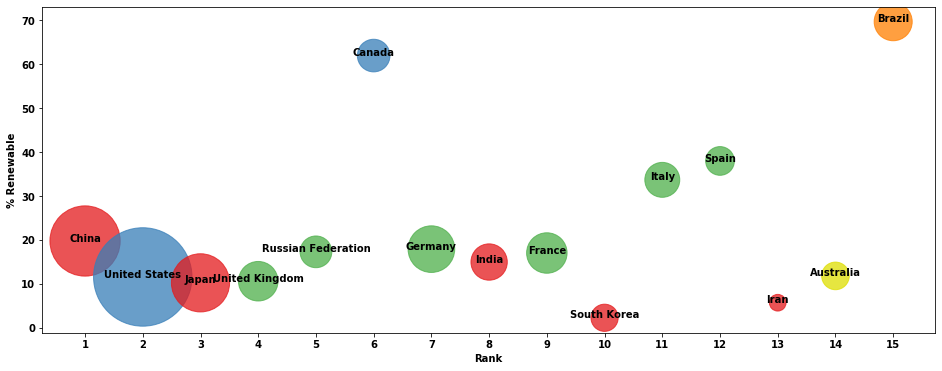

In [16]:
plot_bubbles()